## __[The Learning Agency Lab - PII Data Detection](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data)__
Develop automated techniques to detect and remove PII from educational data.

### Overview
The goal of this competition is to develop a model that detects personally identifiable information (PII) in student writing.

### Data
#### Data Description¶
1. The competition dataset comprises approximately 22,000 essays written by students.
2. A majority of the essays are reserved for the test set (70%)

#### PII Entities
- NAME_STUDENT - The full or partial name of a student that is not necessarily the author of the essay. This excludes instructors, authors, and other person names.
- EMAIL - A student’s email address.
- USERNAME - A student's username on any platform.
- ID_NUM - A number or sequence of characters that could be used to identify a student, such as a student ID or a social security number.
- PHONE_NUM - A phone number associated with a student.
- URL_PERSONAL - A URL that might be used to identify a student.
- STREET_ADDRESS - A full or partial street address that is associated with the student, such as their home address.

#### File and Field Information
- The data is presented in JSON format. 
- The documents were tokenized using the SpaCy English tokenizer.
- Token labels are presented in BIO (Beginning, Inner, Outer) format. (e.g.: Waseem Mabunda and Emily -> B-NAME_STUDENT, I-NAME_STUDENT, O, B-NAME_STUDENT)
- {test|train}.json - the test and training data; the test data given on this page is for illustrative purposes only, and will be replaced during Code rerun with a hidden test set.
  1. (int): the index of the essay
  2. document (int): an integer ID of the essay
  3. full_text (string): a UTF-8 representation of the essay
  4. tokens (string): a string representation of each token (list)
  5. trailing_whitespace (bool): a boolean value indicating whether each token is followed by whitespace (list)
  6. labels (string) [training data only]: a token label in BIO format (list)

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import chain


In [2]:
df_train = pd.read_json('./data/pii-detection-removal-from-educational-data/train.json')
df_test = pd.read_json('./data/pii-detection-removal-from-educational-data/test.json')

In [3]:
df_train.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [4]:
df_test.head()

,document,full_text,tokens,trailing_whitespace
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             6807 non-null   int64 
 1   full_text            6807 non-null   object
 2   tokens               6807 non-null   object
 3   trailing_whitespace  6807 non-null   object
 4   labels               6807 non-null   object
dtypes: int64(1), object(4)
memory usage: 266.0+ KB


In [6]:
# check is number of tokens and labels are equal in training dataset
if not any(len(row[0]) != len(row[1]) for row in df_train[['tokens', 'labels']]):
    print("Number of tokens and labels are equal.")
else:
    print("Number of tokens and labels are NOT equal")

Number of tokens and labels are equal.


In [7]:
def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column, 
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    # show percentage on bar for first 3 bars
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)        
    ax.get_legend().remove()
    plt.show()

def plot_non_pii_entity_doc(df):
    df['non_pii_entity_only'] = df['labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))
    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())

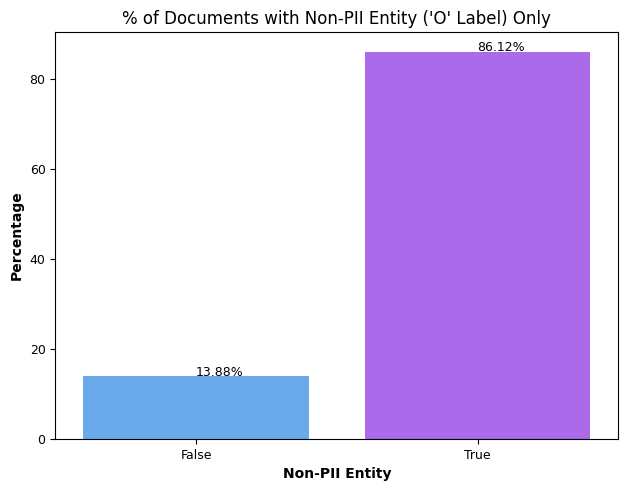

non_pii_entity_only
True     5862
False     945
Name: count, dtype: int64


In [8]:
# check the distribution for non-PII entity, i.e. 'O' label
plot_non_pii_entity_doc(df_train)

In [9]:
# label value counts on the train data
labels_chained = chain.from_iterable(df_train['labels'])
label_counts = Counter(labels_chained)
label_counts

Counter({'O': 4989794,
         'B-NAME_STUDENT': 1365,
         'I-NAME_STUDENT': 1096,
         'B-URL_PERSONAL': 110,
         'B-EMAIL': 39,
         'B-ID_NUM': 78,
         'I-URL_PERSONAL': 1,
         'B-USERNAME': 6,
         'B-PHONE_NUM': 6,
         'I-PHONE_NUM': 15,
         'B-STREET_ADDRESS': 2,
         'I-STREET_ADDRESS': 20,
         'I-ID_NUM': 1})

In [10]:
def plot_distribution(df):
    # label value counts on the train data
    labels_chained = chain.from_iterable(df['labels']) # bind into one list
    label_counts = Counter(labels_chained)
    
    # get labels and counts, excluding "O"
    labels = [l for l in label_counts.keys() if l != 'O']
    counts = [label_counts[l] for l in labels]

    # sort labels and counts together (descending by counts)
    sorted_data = sorted(zip(labels, counts), key=lambda x: x[1], reverse=False)
    sorted_labels, sorted_counts = zip(*sorted_data)

    # create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(sorted_labels, sorted_counts, color='skyblue')

    # add numbers on top of each bar
    for bar, count in zip(bars, sorted_counts):
        xval = bar.get_width()  # Get the width of the bar
        ax.text(xval + 0.1, 
                bar.get_y() + bar.get_height() / 2, 
                str(count), 
                ha='left', 
                va='center',
                fontsize=9)

    plt.xlabel('Count')
    plt.ylabel('Label')
    plt.yticks(rotation=0)
    plt.title('Distribution of Labels (Excluding "O")')

    plt.tight_layout()
    plt.show()
    print("'O' label (%): ", round(label_counts['O']/label_counts.total() * 100, 2))

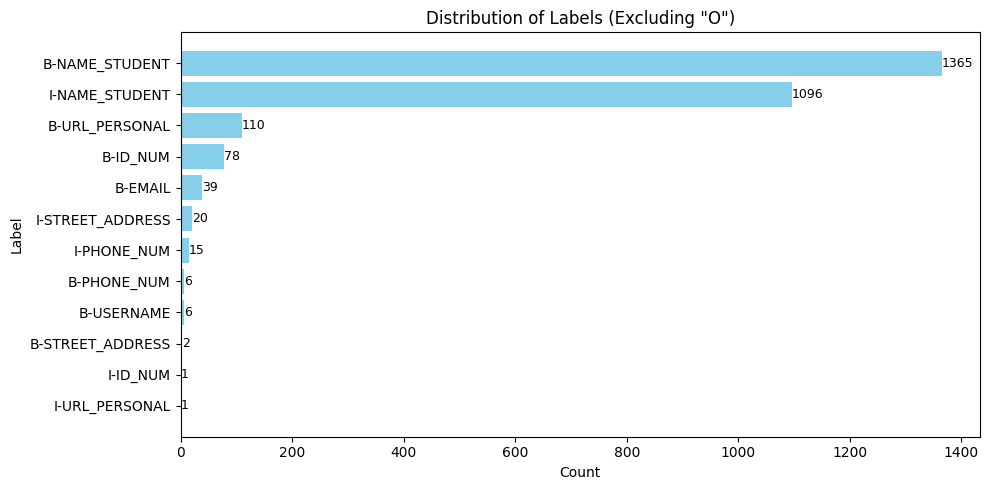

'O' label (%):  99.95


In [11]:
plot_distribution(df_train)

#### Observation
- training dataset has imbalanced classes
- 86.12% of the documents with non-PII entity i.e. 'O' label (non-PII) only
- 99.95% of the labels is non-PII entity ('O' label)
- label 'B-NAME_STUDENT' and 'I-NAME_STUDENT' for entity 'NAME_STUDENT' are have higher frequency compared to others, except 'O' label

#### What we can do
- collect external data to increase label for entities 'ID_NUM', 'EMAIL', 'URL_PERSONAL', 'PHONE_NUM' and 'STREET_ADDRESS'
- down sample 'O' label

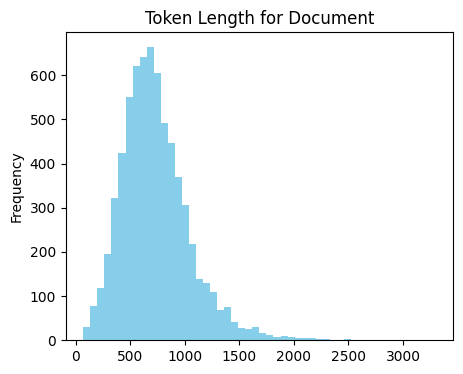

count    6807.000000
mean      733.441017
std       319.244697
min        69.000000
25%       520.000000
50%       693.000000
75%       897.000000
max      3298.000000
Name: token_len, dtype: float64

In [12]:
# check token length
df_train['token_len'] = df_train['tokens'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
df_train['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document")
plt.grid(False)
plt.show()

df_train['token_len'].describe()

In [13]:
df_train['token_len_512_less'] = df_train['token_len'].map(lambda x: x <= 512)
df_train['token_len_512_less'].value_counts()

token_len_512_less
False    5171
True     1636
Name: count, dtype: int64

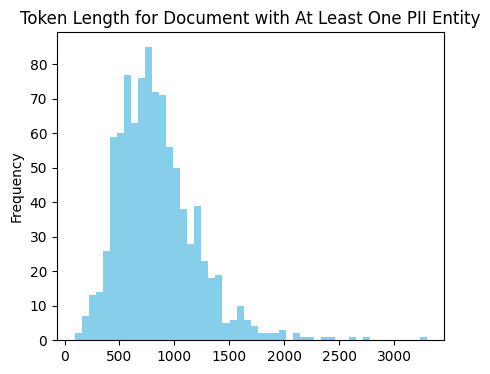

count     945.000000
mean      841.480423
std       363.993251
min        91.000000
25%       585.000000
50%       789.000000
75%      1029.000000
max      3298.000000
Name: token_len, dtype: float64

In [14]:
# check token length for document with at least one PII entity
df_pii = df_train[~df_train['non_pii_entity_only']]

plt.figure(figsize=(5, 4))
df_pii['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document with At Least One PII Entity")
plt.grid(False)
plt.show()

df_pii['token_len'].describe()

In [15]:
df_pii['token_len_512_less'].value_counts()

token_len_512_less
False    785
True     160
Name: count, dtype: int64

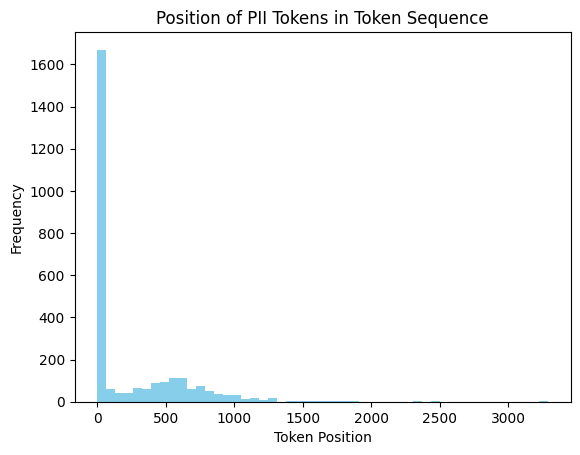

In [16]:
def get_token_index(x):
    return np.array([idx for idx, i in enumerate(x) if i!='O'])

df_pii["labels"].apply(get_token_index).explode().plot.hist(bins=50, color='skyblue')
plt.xlabel("Token Position")
plt.title("Position of PII Tokens in Token Sequence");

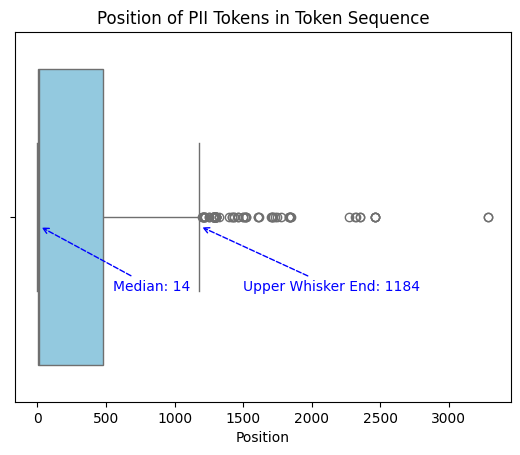

In [17]:
df_pii_token_position = df_pii["labels"].apply(get_token_index).explode().reset_index()
df_pii_token_position.rename(columns={"index": "document", "labels": "position"}, inplace=True)

figplot = sns.boxplot(data=df_pii_token_position, x='position', color='skyblue')
upper_quartile = df_pii_token_position.position.quantile(0.75)
lower_quartile = df_pii_token_position.position.quantile(0.25)
iqr = upper_quartile - lower_quartile
upper_whisker_end = upper_quartile + 1.5 * iqr
figplot.annotate(f'Upper Whisker End: {round(upper_whisker_end)}', 
                     xy=(upper_whisker_end, 0.025), 
                     xytext=(1500, 0.2), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))

median = df_pii_token_position.position.median()
figplot.annotate(f'Median: {round(median)}', 
                     xy=(median, 0.025), 
                     xytext=(550, 0.2), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))
figplot.set_title("Position of PII Tokens in Token Sequence")
figplot.set_xlabel("Position")
plt.show()

In [18]:
print('Total PII entity tokens:', df_pii_token_position['position'].count())

Total PII entity tokens: 2739


In [19]:
print('Total PII entity tokens at position <= 512:', df_pii_token_position[df_pii_token_position['position']<=511]['position'].count())

Total PII entity tokens at position <= 512: 2102


In [20]:
print('Total PII entity tokens at position <= 1184:', df_pii_token_position[df_pii_token_position['position']<=1183]['position'].count())

Total PII entity tokens at position <= 1184: 2670


#### Observation
- minimum token length is 69, maximum token length is 3298
- 31.64% of the documents have token length <= 512
- for documents with at leaset one PII entity, 16.93% of them have token length <= 512
- 76.74% of the PII entity tokens at position <= 512 in a document
- pre-trained transformer models usually take in input sequence with maximumn length of 512, this means tokens at the position > 512 will not be taking for training.

#### What we can do
- use stride in tokenazation process, stride helps break up large document into smaller ones with overlapping tokens
- split the text to multiple sub-texts
- upper whisker end of the position of PII token is 1184, we can fine tune a model which accept longer input sequence to include as much as possible PII tokens without striding the tokens.

## External Data

1. Generated by @nbroad [pii-dd-mistral-generated](https://www.kaggle.com/datasets/nbroad/pii-dd-mistral-generated)

In [21]:
df_nbroad = pd.read_json("./data/pii-dd-mistral-generated/mixtral-8x7b-v1.json")
df_nbroad.head()

,document,full_text,tokens,labels,trailing_whitespace
0,dtduupvzgt,"Tiburce Evans, https://www.instagram.com/tibur...","[Tiburce, Evans, ,, https://www.instagram.com/...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-URL_PERS...","[True, False, True, False, True, True, True, F..."
1,uejmzisyyh,Rose-Mai Rodriguez | PIN # 3814374\n501 Andrea...,"[Rose, -, Mai, Rodriguez, |, PIN, #, 3814374, ...","[B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN...","[False, False, True, True, True, True, True, F..."
2,jzevfvijlw,"Lina Wingate; 095 Terry Via\nTerrymouth, MT 24...","[Lina, Wingate, ;, 095, Terry, Via, \n, Terrym...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-STREET_A...","[True, False, True, True, True, False, False, ..."
3,jqldfongxi,"Lally Scales | Pin # 74,7,9,0, 658-527-2399; l...","[Lally, Scales, |, Pin, #, 74,7,9,0, ,, 658, -...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, B-ID...","[True, True, True, True, True, False, True, Fa..."
4,qzgtouvmtu,"Li Warfield-Fontana; 001-528-777-2370x08989, p...","[Li, Warfield, -, Fontana, ;, 001, -, 528, -, ...","[B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN...","[True, False, False, False, True, False, False..."


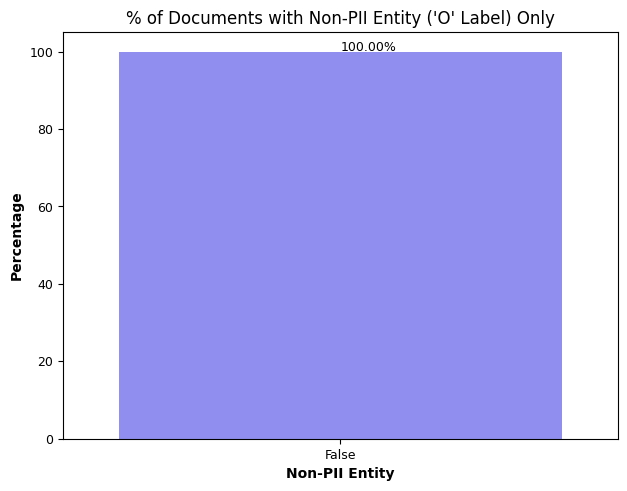

non_pii_entity_only
False    2355
Name: count, dtype: int64


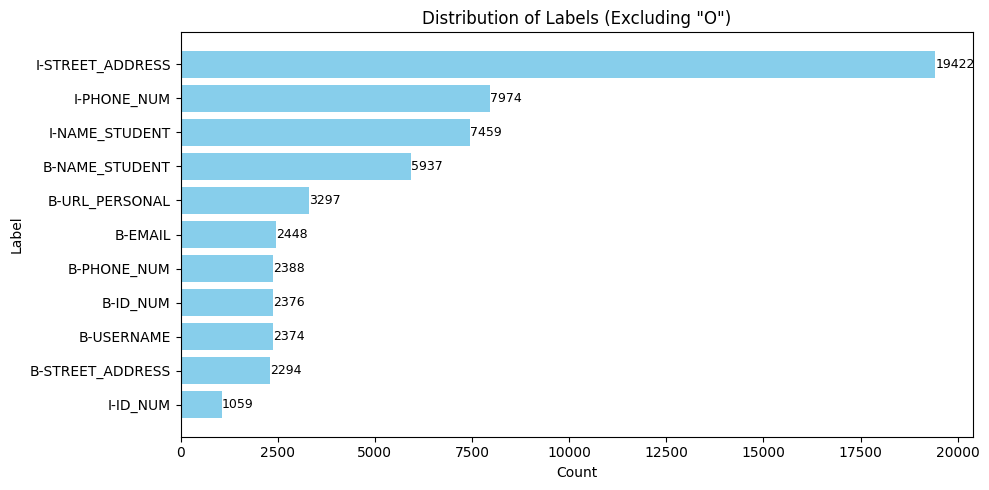

'O' label (%):  97.24


In [22]:
plot_non_pii_entity_doc(df_nbroad)
plot_distribution(df_nbroad)

2. Generated by @valentinwerner [pii-label-specific-data](https://www.kaggle.com/datasets/valentinwerner/pii-label-specific-data)

In [23]:
df_valentinwerner = pd.read_json("./data/pii-label-specific-data/all_labels.json")
df_valentinwerner.head()

,tokens,trailing_whitespace,labels
0,"[ , Title, :, Home, at, 958, Ryan, Ports, ,, J...","[False, False, True, True, True, True, True, F...","[O, O, O, O, O, B-STREET_ADDRESS, I-STREET_ADD..."
1,"[ , Title, :, My, Home, at, 7600, David, Plain...","[False, False, True, True, True, True, True, T...","[O, O, O, O, O, O, B-STREET_ADDRESS, I-STREET_..."
2,"[ , Living, in, PSC, 4747, ,, Box, 7953, APO, ...","[False, True, True, True, False, True, True, T...","[O, O, O, B-STREET_ADDRESS, I-STREET_ADDRESS, ..."
3,"[ , Title, :, Living, at, the, Shores, of, Tra...","[False, False, True, True, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, B-STREET_ADDRES..."
4,"[ , Title, :, My, Home, in, Ballmouth, ,, Verm...","[False, False, True, True, True, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


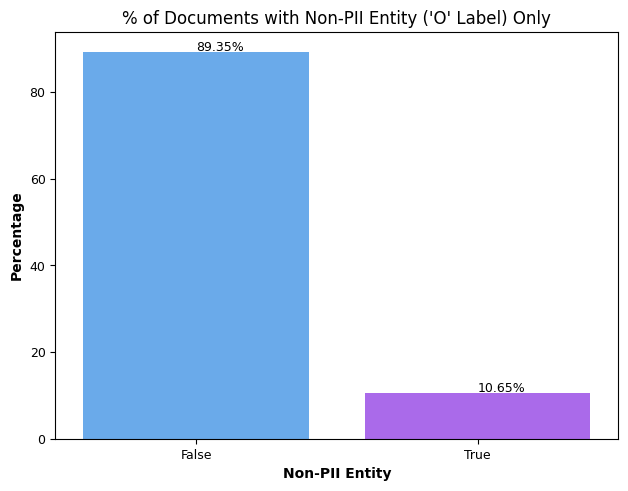

non_pii_entity_only
False    3902
True      465
Name: count, dtype: int64


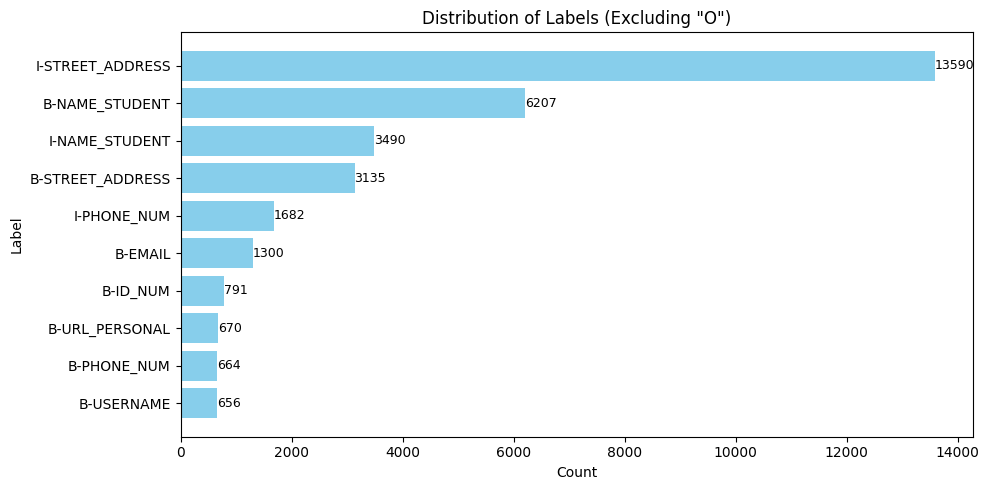

'O' label (%):  97.92


In [24]:
plot_non_pii_entity_doc(df_valentinwerner)
plot_distribution(df_valentinwerner)

3. Generated by @alejopaulier [PII | External Dataset](https://www.kaggle.com/datasets/alejopaullier/pii-external-dataset/data?select=pii_dataset.csv) and fixed by @valentinwerner [fix punctuation tokenization external dataset](https://www.kaggle.com/code/valentinwerner/fix-punctuation-tokenization-external-dataset/notebook)

In [25]:
df_alejopaulier = pd.read_json('./data/fix-punctuation-tokenization-external-dataset/pii_dataset_fixed.json')
df_alejopaulier.head()

,document,full_text,tokens,trailing_whitespace,labels
0,001010b6-de5c-4a96-bd1f-c8b2b0f15ccc,"In my role as a dietician, I have encountered ...","[In, my, role, as, a, dietician, ,, I, have, e...","[True, True, True, True, True, False, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,0016aef8-0d26-45fe-bb7d-ef05311d6383,"Hello, my name is Oleg Ivanova, and I'm a geol...","[Hello, ,, my, name, is, Oleg, Ivanova, ,, and...","[False, True, True, True, True, True, False, T...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
2,00207a69-33cc-4f73-8950-8e01871a2f5e,"My name is Sofia Watanabe, and I'm a passionat...","[My, name, is, Sofia, Watanabe, ,, and, I, 'm,...","[True, True, True, True, False, True, True, Fa...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
3,0036e5b9-031d-421c-850f-fdd4c0f577bd,"In a bustling metropolis, where skyscrapers pi...","[In, a, bustling, metropolis, ,, where, skyscr...","[True, True, True, False, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,004467fb-d131-415a-a638-8539852d92a0,"In 2018, as a cardiologist with 6 years of exp...","[In, 2018, ,, as, a, cardiologist, with, 6, ye...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


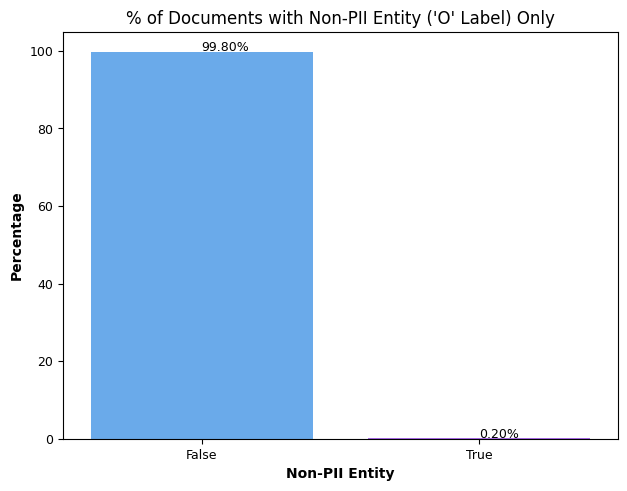

non_pii_entity_only
False    4425
True        9
Name: count, dtype: int64


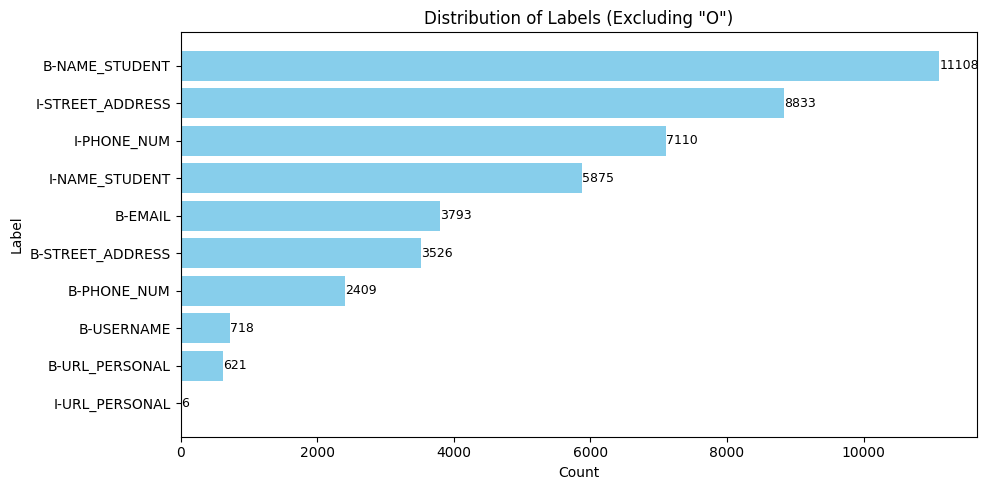

'O' label (%):  97.2


In [26]:
plot_non_pii_entity_doc(df_alejopaulier)
plot_distribution(df_alejopaulier)

4. Generated by @pjmathematician [PII Detection Dataset (GPT)](https://www.kaggle.com/datasets/pjmathematician/pii-detection-dataset-gpt) and fixed by @valentinwerner [fix punctuation tokenization external dataset](https://www.kaggle.com/code/valentinwerner/fix-punctuation-tokenization-external-dataset/notebook)

In [27]:
df_pjmathematician = pd.read_json("./data/fix-punctuation-tokenization-external-dataset/moredata_dataset_fixed.json")
df_pjmathematician.head()

,document,full_text,tokens,trailing_whitespace,labels
0,pj_0,"In today's modern world, where technology has ...","[In, today, 's, modern, world, ,, where, techn...","[True, False, True, True, False, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,pj_1,"In today's modern world, where technology has ...","[In, today, 's, modern, world, ,, where, techn...","[True, False, True, True, False, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,pj_10,The Importance of Embracing Technology in Educ...,"[The, Importance, of, Embracing, Technology, i...","[True, True, True, True, True, True, False, Fa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,pj_100,The Importance of Personal Identity in the Dig...,"[The, Importance, of, Personal, Identity, in, ...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,pj_1000,The Importance of Personal Identity in the Dig...,"[The, Importance, of, Personal, Identity, in, ...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


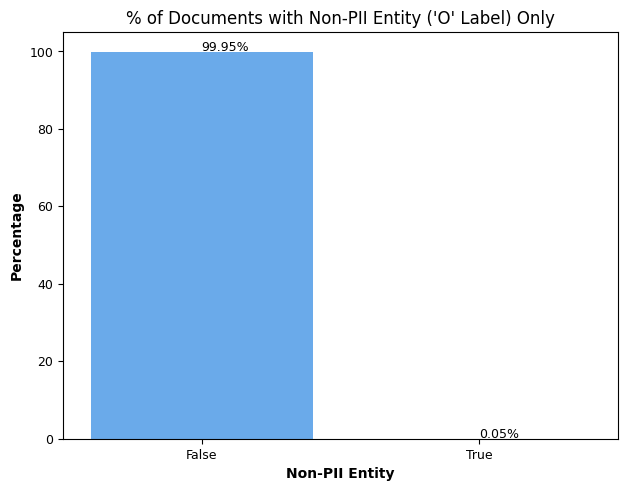

non_pii_entity_only
False    1999
True        1
Name: count, dtype: int64


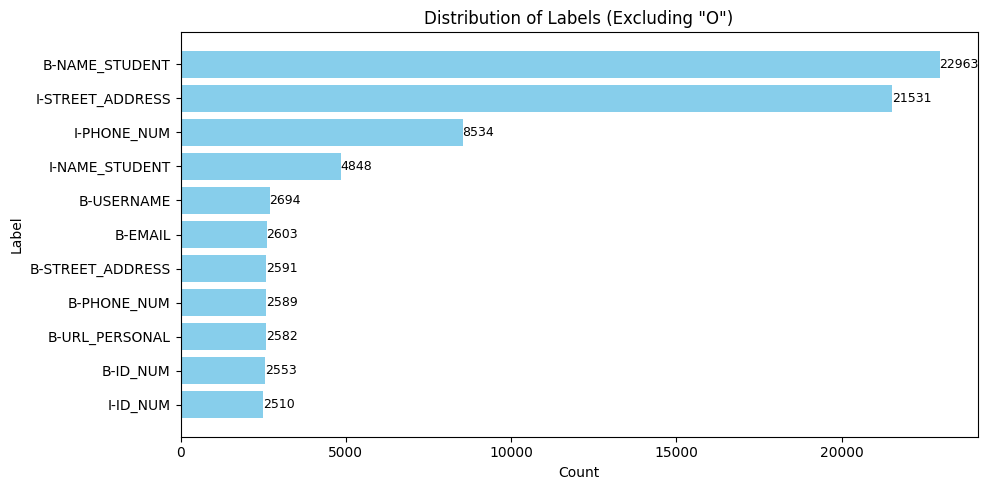

'O' label (%):  92.54


In [28]:
plot_non_pii_entity_doc(df_pjmathematician)
plot_distribution(df_pjmathematician)

5. Generated by @minhsienweng [ai-generated-text-dataset](https://www.kaggle.com/datasets/minhsienweng/ai-generated-text-dataset)

In [29]:
df_minhsienweng = pd.read_json("./data/ai-generated-text-dataset/pii_dataset_Gemma.json")
df_minhsienweng.head()

,document,full_text,tokens,trailing_whitespace,labels
0,1221555001,"Camille Collin, a student whose name is synony...","[Camille, Collin, ,, a, student, whose, name, ...","[True, False, True, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
1,1221555002,"Michael Stewart, a student identified by the I...","[Michael, Stewart, ,, a, student, identified, ...","[True, False, True, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,1221555003,"Lisa Fernandez, a student identified by the ID...","[Lisa, Fernandez, ,, a, student, identified, b...","[True, False, True, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
3,1221555004,"Joshua Vasquez, a student identified by the ID...","[Joshua, Vasquez, ,, a, student, identified, b...","[True, False, True, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
4,1221555005,"Andrew Woodward, a student identified by the I...","[Andrew, Woodward, ,, a, student, identified, ...","[True, False, True, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."


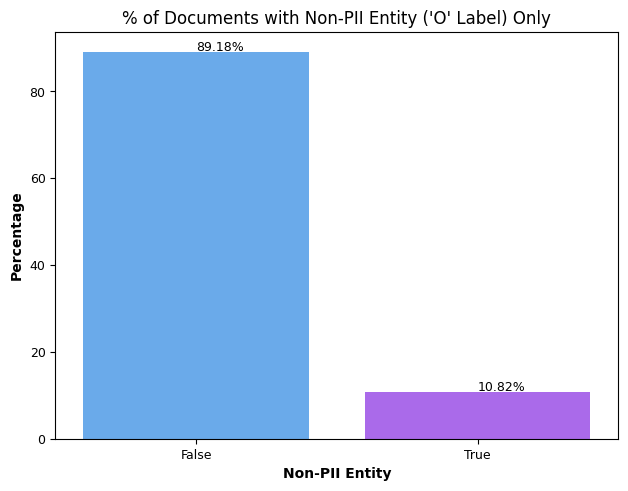

non_pii_entity_only
False    4886
True      593
Name: count, dtype: int64


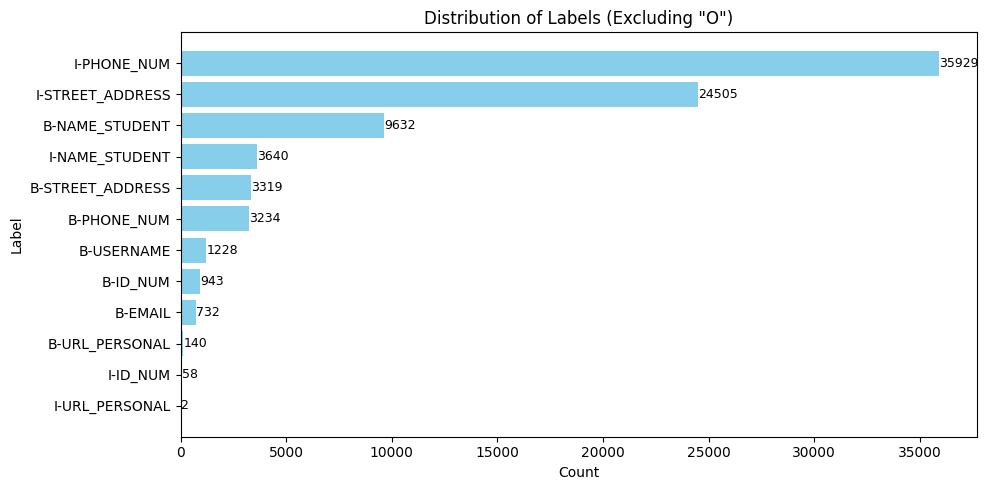

'O' label (%):  95.94


In [30]:
plot_non_pii_entity_doc(df_minhsienweng)
plot_distribution(df_minhsienweng)

6. Generated by @mandrilator [pii-mistral-2k-fit-competition-v2](https://www.kaggle.com/datasets/mandrilator/pii-mistral-2k-fit-competition-v2)

In [31]:
df_mandrilator = pd.read_json("./data/pii-mistral-2k-fit-competition-v2/all_labels.json")
df_mandrilator.head()

,document,full_text,tokens,trailing_whitespace,labels
0,397624475,Title: Mind Mapping My Way Through a Complex ...,"[ , Title, :, Mind, Mapping, My, Way, Through,...","[False, False, True, True, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,688880209,Title: Design Thinking and Mind Mapping: Over...,"[ , Title, :, Design, Thinking, and, Mind, Map...","[False, False, True, True, True, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,235142685,Title: Design Thinking and Mind Mapping: Navi...,"[ , Title, :, Design, Thinking, and, Mind, Map...","[False, False, True, True, True, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,393875156,Title: Design Thinking with Mind Mapping: Ove...,"[ , Title, :, Design, Thinking, with, Mind, Ma...","[False, False, True, True, True, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,751948112,Title: Design Thinking and Visualization: Ove...,"[ , Title, :, Design, Thinking, and, Visualiza...","[False, False, True, True, True, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


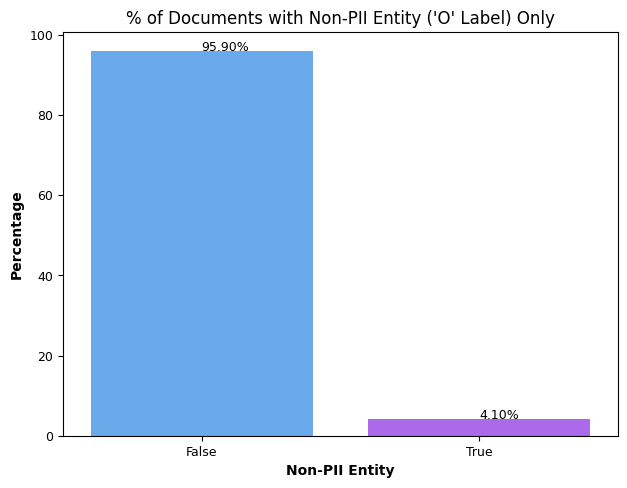

non_pii_entity_only
False    1918
True       82
Name: count, dtype: int64


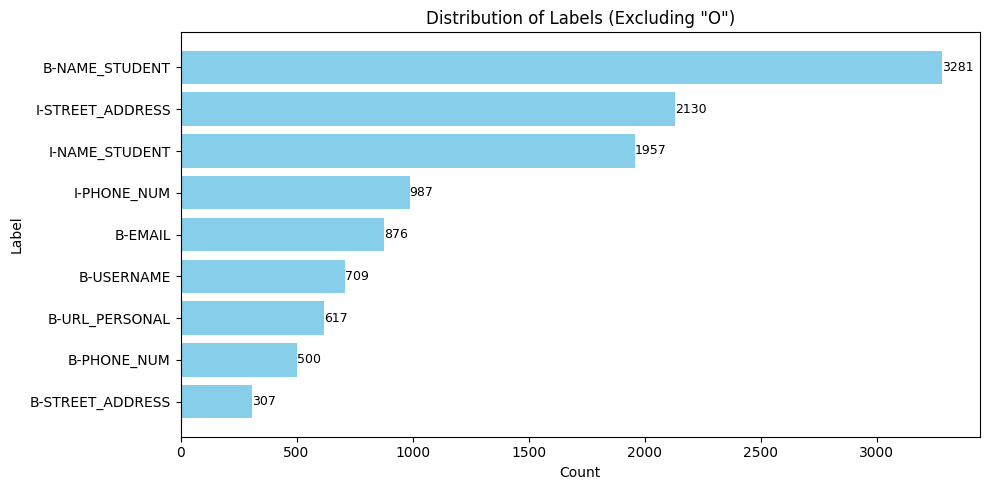

'O' label (%):  99.31


In [32]:
plot_non_pii_entity_doc(df_mandrilator)
plot_distribution(df_mandrilator)

## Combine All Dataset

In [33]:
features = ['tokens', 'labels']

df_concat = pd.concat([df_train[features], 
                       df_nbroad[features], 
                       df_valentinwerner[features], 
                       df_alejopaulier[features], 
                       df_pjmathematician[features],
                       df_minhsienweng[features],
                       df_mandrilator[features]],
                       ignore_index=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tokens  27442 non-null  object
 1   labels  27442 non-null  object
dtypes: object(2)
memory usage: 428.9+ KB


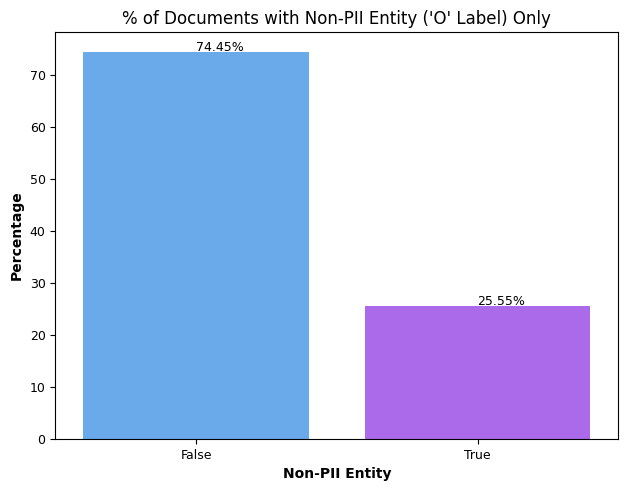

non_pii_entity_only
False    20430
True      7012
Name: count, dtype: int64


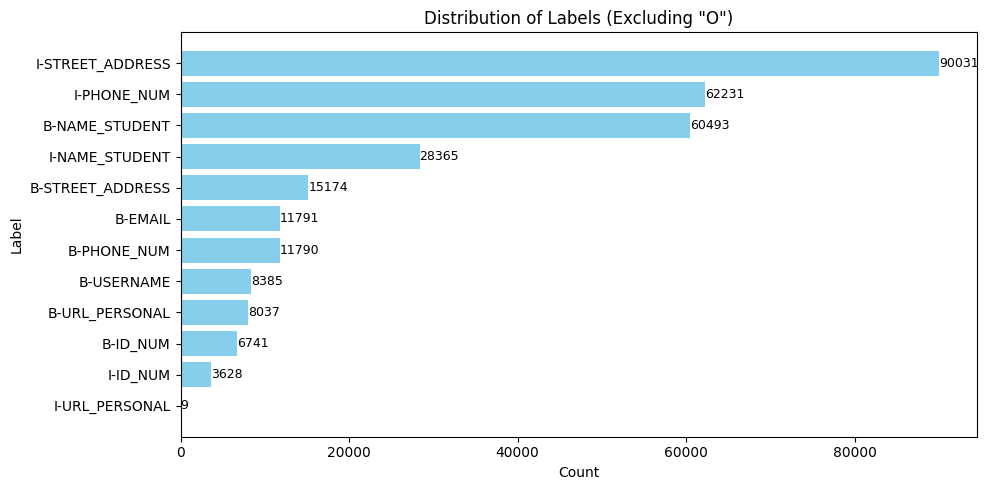

'O' label (%):  97.94


In [34]:
plot_non_pii_entity_doc(df_concat)
plot_distribution(df_concat)

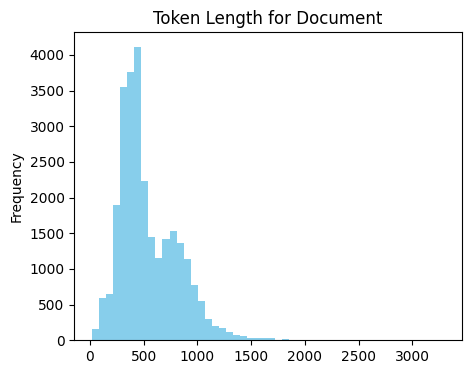

count    27442.000000
mean       542.628926
std        277.570974
min         19.000000
25%        347.000000
50%        459.000000
75%        723.000000
max       3298.000000
Name: token_len, dtype: float64

In [35]:
# check token length
df_concat['token_len'] = df_concat['tokens'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
df_concat['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document")
plt.grid(False)
plt.show()

df_concat['token_len'].describe()

In [36]:
df_concat['token_len_512_less'] = df_concat['token_len'].map(lambda x: x <= 512)
df_concat['token_len_512_less'].value_counts()

token_len_512_less
True     16006
False    11436
Name: count, dtype: int64

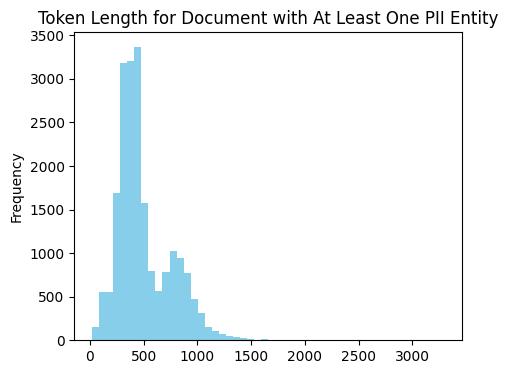

count    20430.000000
mean       497.646500
std        252.600746
min         19.000000
25%        325.000000
50%        429.000000
75%        640.000000
max       3298.000000
Name: token_len, dtype: float64

In [37]:
# check token length for document with at least one PII entity
df_pii = df_concat[~df_concat['non_pii_entity_only']]

plt.figure(figsize=(5, 4))
df_pii['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document with At Least One PII Entity")
plt.grid(False)
plt.show()

df_pii['token_len'].describe()

In [43]:
df_pii['token_len_512_less'].value_counts()

token_len_512_less
True     13660
False     6770
Name: count, dtype: int64

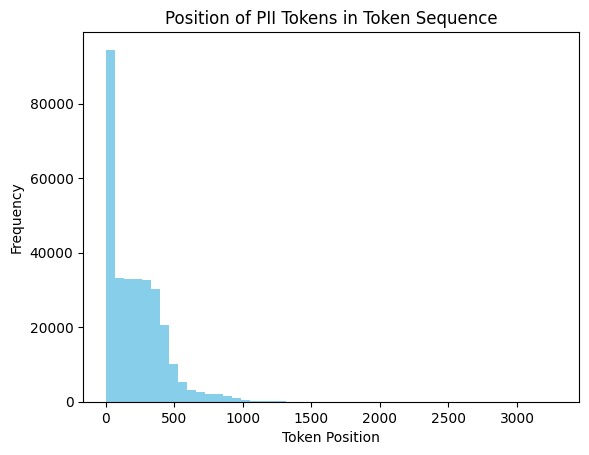

In [38]:
df_pii["labels"].apply(get_token_index).explode().plot.hist(bins=50, color='skyblue')
plt.xlabel("Token Position")
plt.title("Position of PII Tokens in Token Sequence");

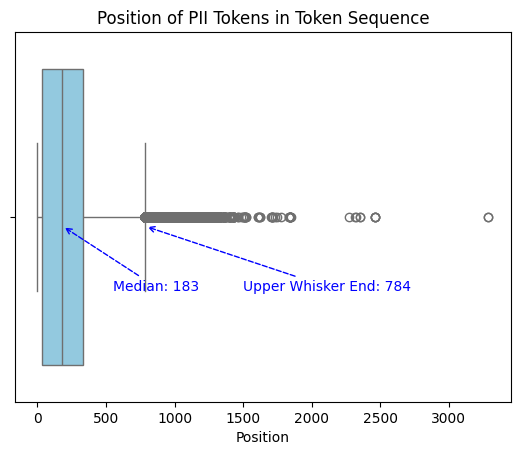

In [39]:
df_pii_token_position = df_pii["labels"].apply(get_token_index).explode().reset_index()
df_pii_token_position.rename(columns={"index": "document", "labels": "position"}, inplace=True)

figplot = sns.boxplot(data=df_pii_token_position, x='position', color='skyblue')
upper_quartile = df_pii_token_position.position.quantile(0.75)
lower_quartile = df_pii_token_position.position.quantile(0.25)
iqr = upper_quartile - lower_quartile
upper_whisker_end = upper_quartile + 1.5 * iqr
figplot.annotate(f'Upper Whisker End: {round(upper_whisker_end)}', 
                     xy=(upper_whisker_end, 0.025), 
                     xytext=(1500, 0.2), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))

median = df_pii_token_position.position.median()
figplot.annotate(f'Median: {round(median)}', 
                     xy=(median, 0.025), 
                     xytext=(550, 0.2), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))
figplot.set_title("Position of PII Tokens in Token Sequence")
figplot.set_xlabel("Position")
plt.show()

In [40]:
print('Total PII entity tokens:', df_pii_token_position['position'].count())

Total PII entity tokens: 306675


In [41]:
print('Total PII entity tokens at position <= 512:', df_pii_token_position[df_pii_token_position['position']<=511]['position'].count())

Total PII entity tokens at position <= 512: 285687


- after combining all the 6 dataset and the train dataset, number of documents increase from 6807 to 27442.
- % of the documents with non-PII entity i.e. 'O' label (non-PII) only decrease to 25.55% from 86.12%
- 97.94% of the labels in combined dataset is non-PII entity ('O' label)
- 58.33% of the documents in combined dataset have token length <= 512
- for documents with at leaset one PII entity, 66.86% of them have token length <= 512
- 93.16% of the PII entity tokens at position <= 512 in a document